In [1]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Exploratory Analysis of the Data

Doing work for the preprocessing and looking at how clean the data is.

In [2]:
path = r"all_reviews.csv"
path_pq = r"steam_reviews.parquet"

con = duckdb.connect()

df = con.execute(f"""
SELECT *
FROM read_csv_auto(?)
LIMIT 4
""", [path]).df()

print(df)

con.execute(f"""
DESCRIBE SELECT * FROM read_csv_auto('{path}')
""").fetchall()

   recommendationid  appid            game     author_steamid  \
0         148919893     10  Counter-Strike  76561199036724879   
1         148919350     10  Counter-Strike  76561198826729322   
2         148913051     10  Counter-Strike  76561199101237625   
3         148912714     10  Counter-Strike  76561198347582422   

   author_num_games_owned  author_num_reviews  author_playtime_forever  \
0                       0                   3                      197   
1                       0                  21                      441   
2                       7                   1                     1440   
3                      11                   4                     1636   

   author_playtime_last_two_weeks  author_playtime_at_review  \
0                             197                        197   
1                              37                        441   
2                            1440                       1313   
3                              83              

[('recommendationid', 'BIGINT', 'YES', None, None, None),
 ('appid', 'BIGINT', 'YES', None, None, None),
 ('game', 'VARCHAR', 'YES', None, None, None),
 ('author_steamid', 'BIGINT', 'YES', None, None, None),
 ('author_num_games_owned', 'BIGINT', 'YES', None, None, None),
 ('author_num_reviews', 'BIGINT', 'YES', None, None, None),
 ('author_playtime_forever', 'BIGINT', 'YES', None, None, None),
 ('author_playtime_last_two_weeks', 'BIGINT', 'YES', None, None, None),
 ('author_playtime_at_review', 'BIGINT', 'YES', None, None, None),
 ('author_last_played', 'BIGINT', 'YES', None, None, None),
 ('language', 'VARCHAR', 'YES', None, None, None),
 ('review', 'VARCHAR', 'YES', None, None, None),
 ('timestamp_created', 'BIGINT', 'YES', None, None, None),
 ('timestamp_updated', 'BIGINT', 'YES', None, None, None),
 ('voted_up', 'BIGINT', 'YES', None, None, None),
 ('votes_up', 'BIGINT', 'YES', None, None, None),
 ('votes_funny', 'BIGINT', 'YES', None, None, None),
 ('weighted_vote_score', 'DOUBLE'

Making a sample dataframe to use for some parts of the EDA.

In [3]:
sample_df = con.execute(f"""
        SELECT *
        FROM parquet_scan(?)
        USING SAMPLE 0.5%
""", [path_pq]).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Unbalanced Rating Variable

In [4]:
print(con.execute("""
SELECT voted_up, COUNT(*) 
FROM parquet_scan(?)
GROUP BY voted_up
""", [path_pq]).df())



   voted_up  count_star()
0     False      16412862
1      True      97470855


In [5]:
pos = 97470855
neg = 16412862
print(f"pct of positive reviews = {round((pos / (pos + neg)), 4)}")

pct of positive reviews = 0.8559


Looking at the variable that shows whether someone left a review with an upvote or downvote it seems that there were many more positive reviews than negative with there being 86% positive reviews in the data set. This makes sense as people are much more likely to go in and leave a positive review for a game they like than someone is who didn't like it as people who don't like it will probably just stop playing. Only people who really hated the game or had major issues usually leave a negative review. This is important though to think about as this is unbalanced data so need to account for this. Some ideas for what to do when doing the analysis is going month by month and looking at games specifically that release with a lot of negative reviews or have spikes of negative reviews to see how the games respond to this.

### Overall Time-frame check

In [6]:
df_time_check = con.execute("""
SELECT 
    MIN(timestamp_created) AS min_time,
    MAX(timestamp_created) AS max_time
FROM parquet_scan(?)
""", [path_pq]).df()

print(df_time_check)

                   min_time                  max_time
0 2010-10-15 15:24:52-07:00 2023-11-03 09:16:25-07:00


The timeframe of the data set seems really good as it has data from 2010 until 2023.

### Reviews Over Time

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

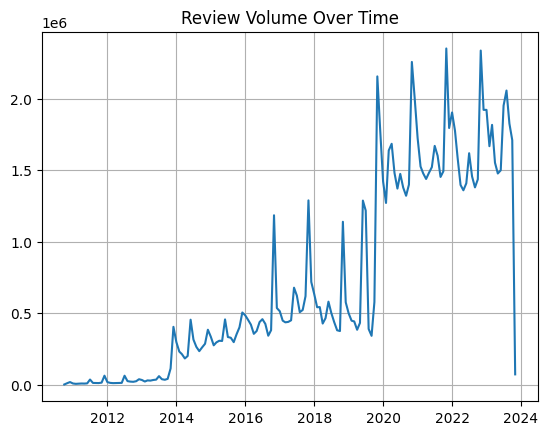

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

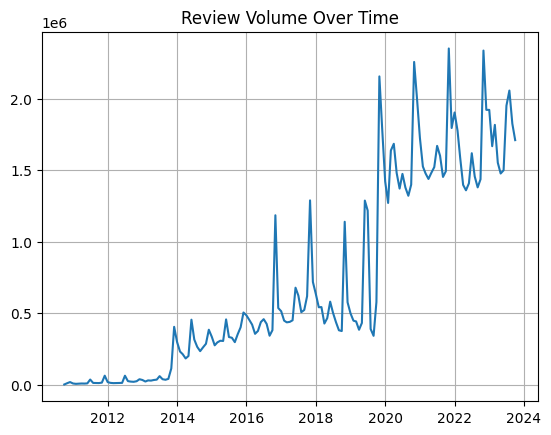

In [31]:
df_reviews_time = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    COUNT(*) AS review_count
FROM parquet_scan(?)
GROUP BY month
ORDER BY month
""", [path_pq]).df()

plt.plot(df_reviews_time["month"], df_reviews_time["review_count"])
plt.title("Review Volume Over Time")
plt.grid(True)
plt.show()

df_reviews_time = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    COUNT(*) AS review_count
FROM parquet_scan(?)
WHERE timestamp_created < '2023-11-01'
GROUP BY month
ORDER BY month
""", [path_pq]).df()

plt.plot(df_reviews_time["month"], df_reviews_time["review_count"])
plt.title("Review Volume Over Time")
plt.grid(True)
plt.show()

Review volume looks accurate with increasing steady over time until a huge spike when covid started as this makes sense since a ton of people started playing video games in this time. There is a sudden drop at the end of the data set which is a little weird so might want to cut off right before then. Cutting off the last two days in the dataset appears to fix this issue.

### Overall Sentiment Over Time

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

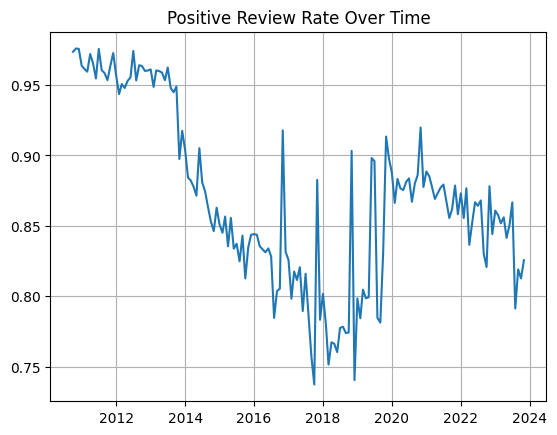

In [8]:
df_sentiment_time = con.execute("""
SELECT 
    DATE_TRUNC('month', timestamp_created) AS month,
    AVG(CAST(voted_up AS INT)) AS positive_rate
FROM parquet_scan(?)
GROUP BY month
ORDER BY month
""", [path_pq]).df()

plt.plot(df_sentiment_time["month"], df_sentiment_time["positive_rate"])
plt.title("Positive Review Rate Over Time")
plt.grid(True)
plt.show()

This graph makes a lot of sense as at the start of the data set the volume of reviews was much lower than later years so it was mostly just people who were big fans of games giving reviews until gaming became more mainstreamed later on which is why the positive review rate drops over time but stabilizes after review volume also stabilized.

### Null Check

In [9]:
null_check = con.execute("""
SELECT 
    COUNT(*) AS total_rows,
    SUM(timestamp_created IS NULL) AS null_timestamps,
    SUM(voted_up IS NULL) AS null_sentiment,
    SUM(appid IS NULL) AS null_appid
FROM parquet_scan(?)
""", [path_pq]).df()

print(null_check)

   total_rows  null_timestamps  null_sentiment  null_appid
0   113883717              0.0             0.0         0.0


This is great because we do not have any null values in our most important values so we do not have to deal with any decisions regarding null values.

### Top Games Review Count

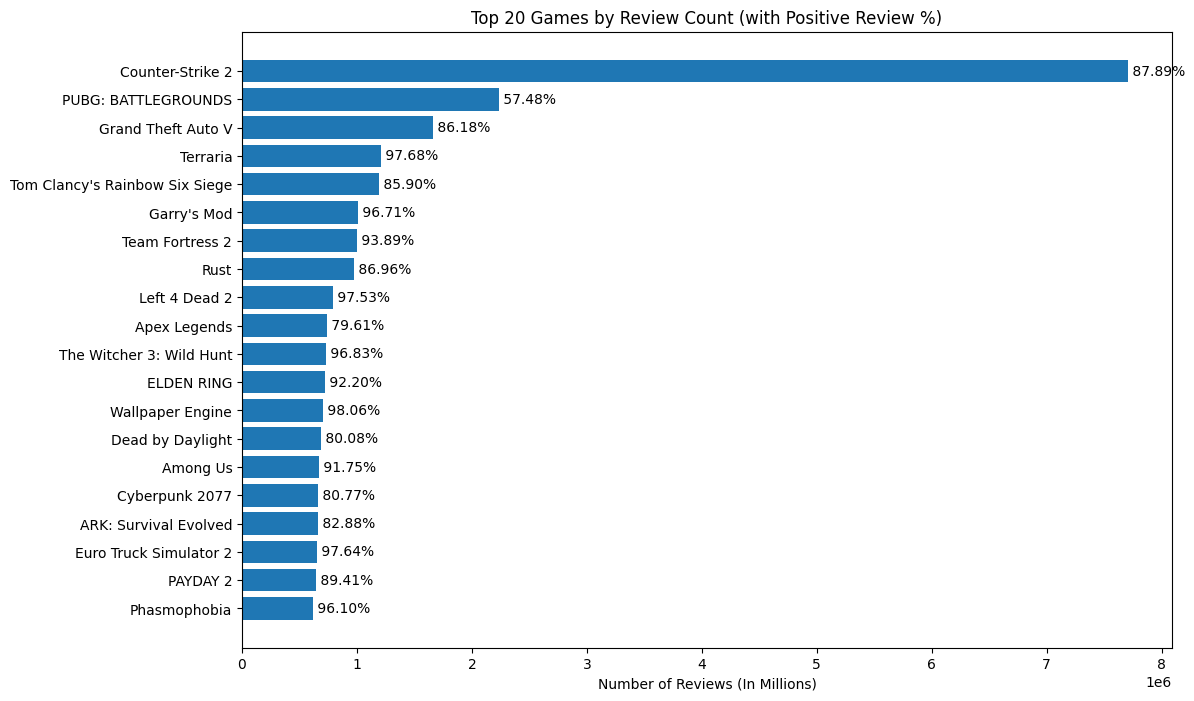

In [10]:
top_games = con.execute("""
    SELECT game, COUNT(*) AS total_reviews, AVG(CAST(voted_up AS INT)) AS positive_rate_pct
    FROM parquet_scan(?)
    GROUP BY game
    ORDER BY total_reviews DESC
    LIMIT 20
    """,
    [path_pq]).df()

plt.figure(figsize=(12, 8))
plt.barh(top_games["game"], top_games["total_reviews"])
plt.xlabel("Number of Reviews (In Millions)")
plt.title("Top 20 Games by Review Count (with Positive Review %)")
plt.gca().invert_yaxis()

for i, (count, pct) in enumerate(zip(top_games["total_reviews"], top_games["positive_rate_pct"])):
    plt.text(
        count,
        i,
        f" {pct:.2%}", 
        va="center"
    )
plt.show()


The dataset is highly imbalanced across games, with a small number of popular titles (Counter-Strike 2, PUBG, and Grand Theft Auto V) contributing millions of reviews each. This dominance suggests that aggregated sentiment trends over time may primarily reflect the review patterns of a few high-engagement games rather than the broader Steam ecosystem. As a result, analyzing sentiment at the individual game level or by game review count groups may provide more accurate insights into developer responsiveness and sentiment evolution.

### Players Playtime Distribution

In [11]:
sample_df["author_playtime_forever"].describe()

count    5.383990e+05
mean     1.683426e+04
std      4.559865e+04
min      0.000000e+00
25%      7.160000e+02
50%      2.913000e+03
75%      1.220700e+04
max      2.743970e+06
Name: author_playtime_forever, dtype: float64

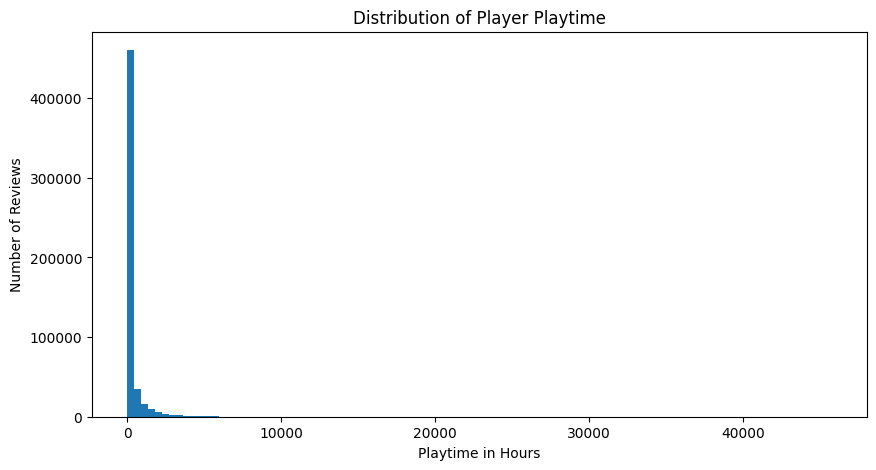

In [12]:
playtime_hours = sample_df["author_playtime_forever"] / 60

plt.figure(figsize=(10,5))
plt.hist(playtime_hours, bins=100)
plt.xlabel("Playtime in Hours")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Player Playtime")
plt.show()

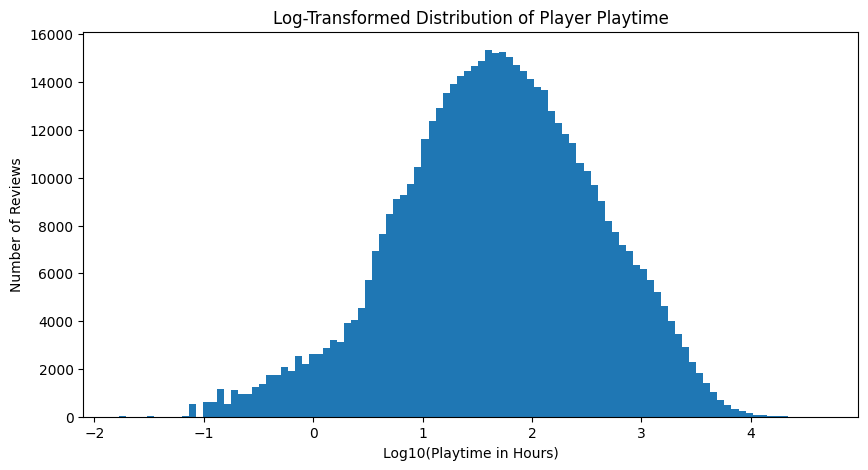

In [13]:
playtime_hours = sample_df["author_playtime_forever"] / 60
playtime_hours = playtime_hours[playtime_hours > 0]
log_playtime = np.log10(playtime_hours)

plt.figure(figsize=(10, 5))
plt.hist(log_playtime, bins=100)
plt.xlabel("Log10(Playtime in Hours)")
plt.ylabel("Number of Reviews")
plt.title("Log-Transformed Distribution of Player Playtime")
plt.show()

The distribution from the random sample of the dataset is of player playtime which is extremely right skewed with a heavy tail and a large number of near zero values. This makes sense as on average people play games casually but some people have extremely high video game playtime hours like people who are just addicted or those who have made a career out of video games. Also, some people "afk" in a game which is where you leave the game on for some reason that depends on what the game is so these people would have extremely high game playtime hours as even though they aren't actually playing steam records these users as still playing.

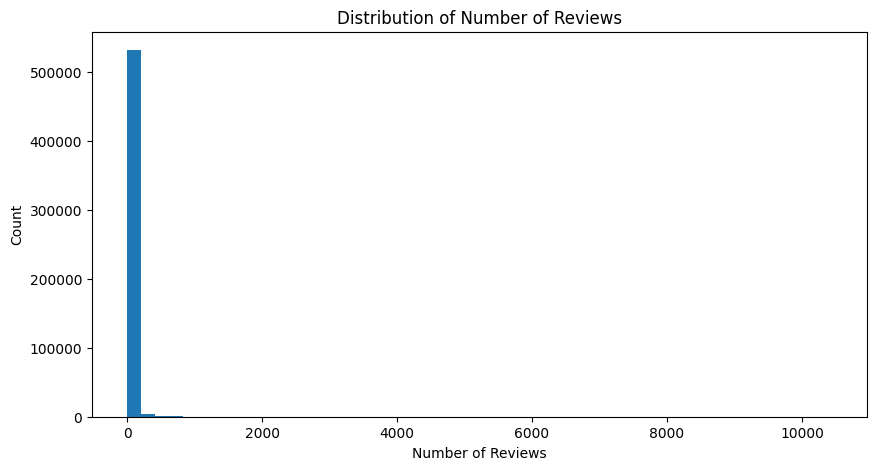

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   min_reviews  max_reviews  avg_reviews  median  p90  p95  p99  p995  p999
0            1        10446    26.827173       6   43   78  301   583  2703


In [27]:
author_rev = sample_df["author_num_reviews"]

plt.figure(figsize=(10,5))
plt.hist(author_rev, bins = 50)
plt.xlabel("Number of Reviews")
plt.ylabel("Count")
plt.title("Distribution of Number of Reviews")
plt.show()

review_quantiles = con.execute("""
SELECT 
    MIN(author_num_reviews) AS min_reviews,
    MAX(author_num_reviews) AS max_reviews,
    AVG(author_num_reviews) AS avg_reviews,
    APPROX_QUANTILE(author_num_reviews, 0.50) AS median,
    APPROX_QUANTILE(author_num_reviews, 0.90) AS p90,
    APPROX_QUANTILE(author_num_reviews, 0.95) AS p95,
    APPROX_QUANTILE(author_num_reviews, 0.99) AS p99,
    APPROX_QUANTILE(author_num_reviews, 0.995) AS p995,
    APPROX_QUANTILE(author_num_reviews, 0.999) AS p999
FROM parquet_scan(?)
""", [path_pq]).df()

print(review_quantiles)

To decide on a cutoff of the max number of reviews an author can have in the dataset I am going to cut it off by the 99.5th percentile to remove extreme outliers. This appears to be the best cutoff with there being a huge jump in the number of reviews between the 99.5th and 99.9th percentiles so these are probably for the most part bot reviews. Also at the same time having people with nearly 600 reviews seems more of legit high engaged users that have been gaming for many years instead of bot reviews.

### Reviews with Zero Playtime

In [14]:
(sample_df["author_playtime_forever"] == 0).mean()

np.float64(0.005679802525636192)

Just did this to check if there were a large amount of reviews with people that had 0 playtime minutes but this is a very small percent (~ .5%) so this isn't concerning for the analysis.

### Language Distribution (Overall Counts and Percent each makes up of Dataset)

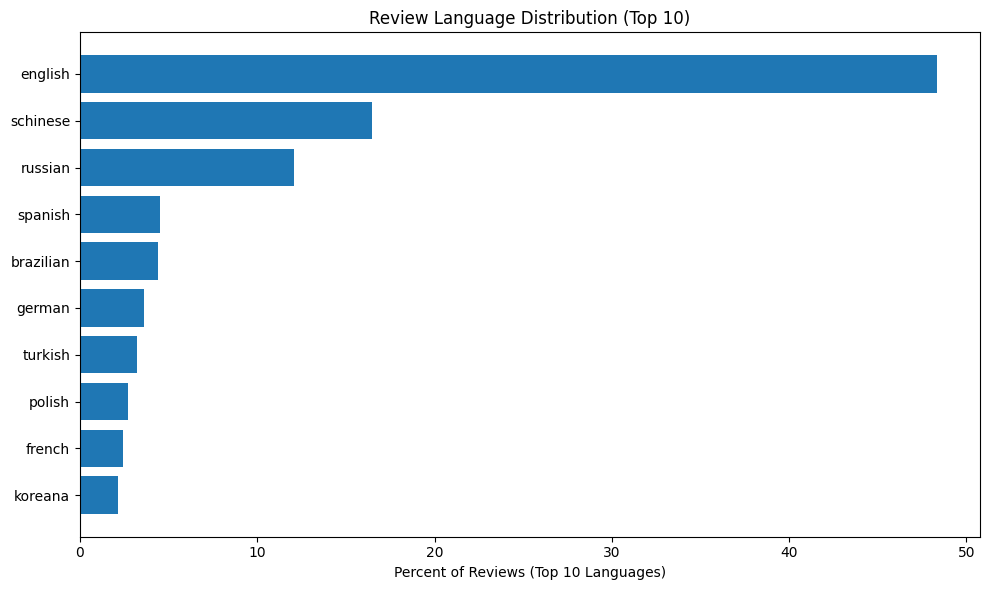

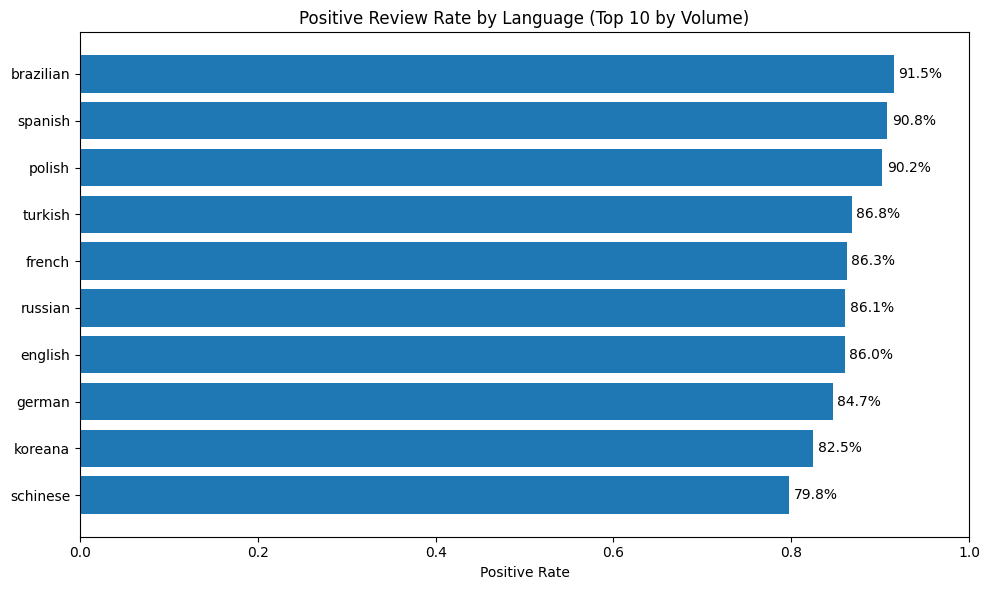

In [15]:
lang_dist = con.execute("""
SELECT language, COUNT(*) AS count_lang
FROM parquet_scan(?)
GROUP BY language
ORDER BY count_lang DESC
LIMIT 10
""", [path_pq]).df()

lang_dist["percent"] = (
    lang_dist["count_lang"] / lang_dist["count_lang"].sum()
) * 100

lang_dist = lang_dist.sort_values("count_lang", ascending=True)

plt.figure(figsize=(10,6))
plt.barh(lang_dist["language"], lang_dist["percent"])
plt.xlabel("Percent of Reviews (Top 10 Languages)")
plt.title("Review Language Distribution (Top 10)")
plt.tight_layout()
plt.show()


lang_pos_rate = con.execute("""
SELECT 
    language,
    AVG(CAST(voted_up AS INT)) AS positive_rate,
    COUNT(*) AS n
FROM parquet_scan(?)
GROUP BY language
ORDER BY n DESC
LIMIT 10
""", [path_pq]).df()

lang_pos_rate = lang_pos_rate.sort_values("positive_rate", ascending=True)

plt.figure(figsize=(10,6))
plt.barh(lang_pos_rate["language"], lang_pos_rate["positive_rate"])
for i, v in enumerate(lang_pos_rate["positive_rate"]):
    plt.text(v + 0.005, i, f"{v:.1%}", va="center")
plt.xlabel("Positive Rate")
plt.title("Positive Review Rate by Language (Top 10 by Volume)")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


Found that there is roughly only 48% of reviews in the data set are in english. This could be problematic because to look at sentiment over time, cultural differences in review behavior may influence the overall sentiment trends independently of actual game improvements. Also looking at the positive ratings of each different language there are big differences between the languages as although the percent differences aren't huge with such a big data set these differences are definitely significant. So, I will only look at english reviews to try and limit this outside variation as much as possible when I am doing my analysis so cultural differences or game versions by different government restrictions do not affect my results.

### Looking into Edited Reviews

  edited_review_ratio
0              12.02%


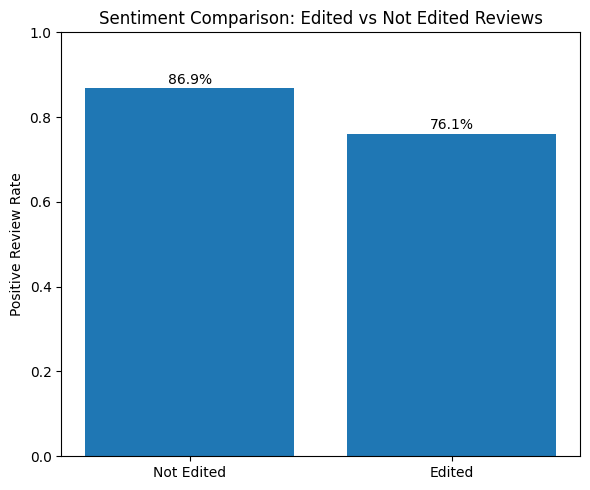

In [16]:
edit_ratio = con.execute("""
SELECT 
    AVG(CASE 
        WHEN timestamp_updated > timestamp_created THEN 1 
        ELSE 0 
    END) AS edited_review_ratio
FROM parquet_scan(?)
""", [path_pq]).df()

edit_ratio["edited_review_ratio"] = (
    edit_ratio["edited_review_ratio"] * 100
).map(lambda x: f"{x:.2f}%")

print(edit_ratio)

edit_sentiment = con.execute("""
SELECT 
    CASE 
        WHEN timestamp_updated > timestamp_created THEN 'Edited'
        ELSE 'Not Edited'
    END AS review_type,
    AVG(CAST(voted_up AS INT)) AS positive_rate,
    COUNT(*) AS n
FROM parquet_scan(?)
GROUP BY review_type
""", [path_pq]).df()

plt.figure(figsize=(6,5))
plt.bar(edit_sentiment["review_type"], edit_sentiment["positive_rate"])

for i, v in enumerate(edit_sentiment["positive_rate"]):
    plt.text(i, v + 0.01, f"{v:.1%}", ha="center")

plt.ylim(0, 1)
plt.ylabel("Positive Review Rate")
plt.title("Sentiment Comparison: Edited vs Not Edited Reviews")
plt.tight_layout()
plt.show()

Looking at review edit behavior shows that approximately 12% of reviews were edited after their initial posting. The edited reviews show a significantly lower positive rate about 76.1% compared to non-edited reviews about 86.9%. The dataset records only the final state of each review, meaning that edited reviews overwrite their original sentiment rather than creating new entries. So, the sentiment variable (voted_up) reflects the reviewer’s most recent opinion, while the timestamp corresponds to the original review date. This introduces a confounding limitation, as sentiment trends over time may partially reflect revised opinions rather than purely initial player reactions, but I think it would be better to keep edited reviews because they capture meaningful sentiment and player responses to updates and game improvements. This is just going to be something I will have to pay attention to in the analysis and try to come up with a way to affectively handle it without removing it entirely.

### Total Amount of Games

In [17]:
unique_games = con.execute("""
SELECT COUNT(DISTINCT appid) AS num_games
FROM parquet_scan(?)
""", [path_pq]).df()

unique_games


   num_games
0     105893


Just did a quick check to see the amount of games that were in the data set to make sure the reviews didn't only represent some games. Although with there being 100,000+ games in this dataset it is safe to say that this is pretty representative of Steam games overall as it has tons of smaller games in the dataset.

### Time Span of Most Reviewed Games in Dataset

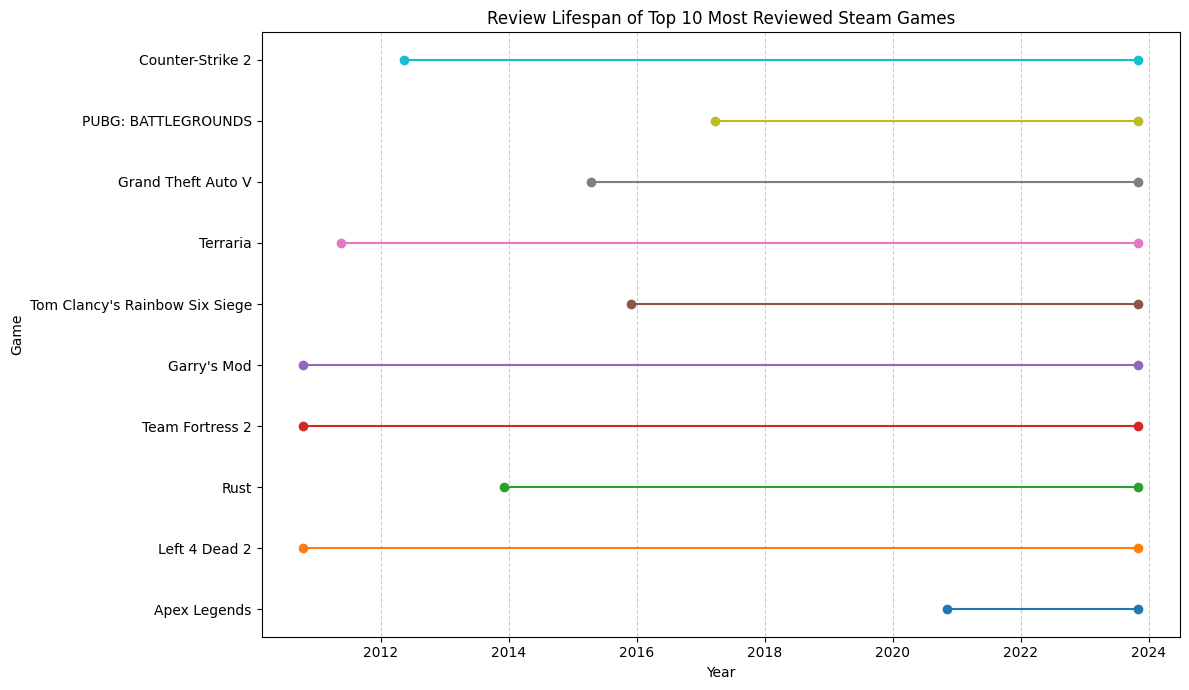

In [18]:
game_time_span = con.execute("""
SELECT 
    game,
    MIN(timestamp_created) AS first_review,
    MAX(timestamp_created) AS last_review,
    COUNT(*) AS total_reviews
FROM parquet_scan(?)
GROUP BY game
ORDER BY total_reviews DESC
LIMIT 10
""", [path_pq]).df()


game_time_span = game_time_span.sort_values("total_reviews", ascending=True)

plt.figure(figsize=(12, 7))

for i, row in game_time_span.iterrows():
    plt.plot(
        [row["first_review"], row["last_review"]],
        [row["game"], row["game"]],
        marker="o"
    )

plt.xlabel("Year")
plt.ylabel("Game")
plt.title("Review Lifespan of Top 10 Most Reviewed Steam Games")
plt.grid(True, axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


A lifespan timeline of the top 10 most reviewed games shows that many titles maintain active review activity for over a decade capturing reviews from there release until the end of the dataset. Games such as Terraria, Team Fortress 2, and Counter-Strike exhibit continuous engagement from early 2010s through 2023, showing that the dataset captures actual long-term player sentiment rather than just short-lived review bursts. This supports the validity of my research hypothesis, as long-term review coverage is necessary to analyze how player sentiment evolves in response to game updates, developer feedback, and lifecycle changes.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   min_len  max_len     avg_len  median_len  p95_len  p99_len  p999_len
0        1  9801289  185.733377          40      806     2372      6347


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

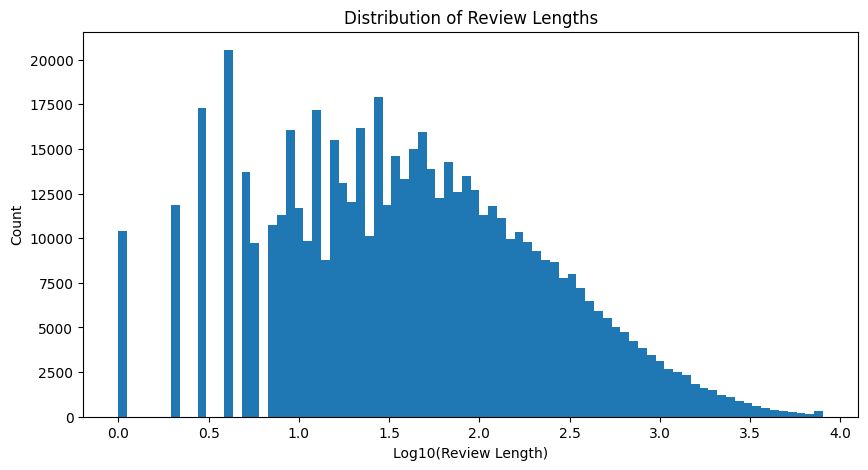

In [38]:
review_stats = con.execute("""
SELECT 
    MIN(LENGTH(review)) AS min_len,
    MAX(LENGTH(review)) AS max_len,
    AVG(LENGTH(review)) AS avg_len,
    APPROX_QUANTILE(LENGTH(review), 0.50) AS median_len,
    APPROX_QUANTILE(LENGTH(review), 0.95) AS p95_len,
    APPROX_QUANTILE(LENGTH(review), 0.99) AS p99_len,
    APPROX_QUANTILE(LENGTH(review), 0.999) AS p999_len
FROM parquet_scan(?)
WHERE review IS NOT NULL
""", [path_pq]).df()

print(review_stats)

review_sample = con.execute("""
SELECT 
    LENGTH(review) AS review_len
FROM parquet_scan(?)
WHERE review IS NOT NULL
USING SAMPLE 0.5%
""", [path_pq]).df()

lens = review_sample["review_len"]
lens = lens[lens > 0]

plt.figure(figsize=(10,5))
plt.hist(np.log10(lens), bins=80)
plt.xlabel("Log10(Review Length)")
plt.ylabel("Count")
plt.title("Distribution of Review Lengths")
plt.show()

## Data Parsing and Preprocessing Issues

### 1. Extremely Large Dataset Size (≈40GB CSV)
The original dataset was about 40GB in CSV format and contained over 100 million reviews. Loading the full dataset into memory using pandas was not possible due to memory limitations. Attempting to read the entire CSV file would result in excessive RAM usage and really long processing times.

So in order to resolve this, I used DuckDB to query the dataset directly from the disk which allows for SQL-based analysis without loading the entire dataset into memory. Also, I converted the dataset to a compressed Parquet file to significantly improve query speed and reduce file size.

### 2. CSV Parsing Errors Due to Extremely Long Review Text
When I went to preprocess the file into a Parquet file the CSV parser produced errors related to maximum line size being exceeded. Some review text fields contained extremely long strings (multi megabyte lines), which caused parsing failures when using default CSV settings.

To account for this issue, I used the max_line_size=20000000 to account for this which allowed me to make the Parquet file. I also did not include the actual reviews in my Parquet file as of now because I did not think the actual review text would be important for the analysis but if I end up needing it I am going to add it later. Including it right now would just add a ton of file size that is unneeded.

### 3. Timestamp Conversion from Unix Format
The dataset stored temporal variables (timestamp_created, timestamp_updated, author_last_played) as Unix timestamps rather than human-readable datetime values. This created an initial parsing challenge for time-series analysis.

These fields were converted to proper timestamp formats using SQL functions (TO_TIMESTAMP) in DuckDB which enables accurate time aggregation and visualization for the sentiment analysis.

### 4. Jupyter Output and Sampling Constraints
Due to the scale of the dataset, attempting to display large query outputs in Jupyter caused IOPub message rate limit warnings. This indicated that large result sets could overwhelm the notebook interface even when computation succeeded.

To mitigate this, random sampling (0.5% sampling is what I did) was used during exploratory data analysis for some parts to efficiently inspect distributions and trends while maintaining representativeness of the full dataset. I chose to do just a random sample and not only do all reviews for a select amount of games because I wanted general trends of the population of the dataset to still be captured.

### 5. Final-State Review Overwriting (Edited Reviews)
The dataset records only the final state of each review which means that edited reviews overwrite their original sentiment rather than creating new entries. This introduces a parsing and interpretability limitation, as the sentiment variable reflects the reviewer’s most recent opinion while the timestamp corresponds to the original review date.

This limitation was retained rather than filtered because edited reviews provide meaningful insight into changing player sentiment over time, which is directly relevant to my research hypothesis. So I will just handle this in my actual analysis, so it doesn't skew my results without taking it out entirely.

### 6. Amount of Time Played
The dataset contains many reviews of people with zero time played ever so eliminating these would be good since these are most likely either bot/spam reviews or just some outside factor of something that is not relevant to what we want in this study. 

I thought about capping the playtime max to a certain time but finding a max timeframe would be very hard to do since people that are extremely commited to their game might have extremely high hours due to leaving the game running 24/7 to AFK farm or something else depending on the game. Since these extremely commited players reviews are important, I decided not to cap off the timeframe.

### 7. Each Players Number of Reviews
Due to an extremely right skewed distribution of the number of reviews for each author from the sampled dataframe. It appears that there are many bot accounts that most likely are spamming reviews for one game or across multiple games in the steam dataset. So to decide on a cutoff of the max number of reviews an author can have in the dataset I am going to cut it off by the 99.5th percentile to remove extreme outliers. This appears to be the best cutoff with there being a huge jump in the number of reviews between the 99.5th and 99.9th percentiles so these are probably for the most part bot reviews. Also at the same time having people with nearly 600 reviews seems more of legit high engaged users that have been gaming for many years instead of bot reviews.

### 8. Sudden Drop Off at End of Dataset
There is a sudden drop-off in review volume at the end of the dataset which is probably due to a data collection error so in order to account for this I am going to set a date cutoff in the preprocessing. This is just so there aren't any misleading time trends in the actual analysis. By setting the cutoff to timestamp_created < '2023-11-01' this fixes the issue and barely loses any data as this is two days before the dataset ends.

### 9. Massive Review Lengths
When initially reading in the reviews there were some that were massive with the largest one being almost 10 million characters long. So, this is extremely evident of being bot reviews and not ones we want to include in the analysis. To account for this I am going to cut off the reviews to ones that are shorter than 5000 characters in length. This is because it keeps about 99.8% of the reviews and will remove all the ones that are definitely bot reviews / spam. In the graph it can be seen that at the log10 of 3 which is around 1000 characters there are many genuine long reviews that exist so making the review cut off to be around 5000 seems to be a good cutoff since it is highly unlikely a real person is writing a review longer than this and it doesn't remove a huge amount of the data.